# MA 346 Project 1
### Logan Chalifour & Patrick Geitner 

#### Objective:
In this project, we determine if there is any correlation between the spread of COVID-19 and the results of the 2016
presidential election at the state-level while also fitting a logistic model to predict the number of cases for each state.

### Importing Data

Let's start by importing some packages that we'll need.

In [186]:
import pandas as pd
from scipy.optimize import curve_fit
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Next, we will import three CSV files that we'll be using in our analysis. 
We will use `State` as our index so we can merge them more easily later.
The three datasets include information about state populations, COVID-19 cases, and election results from
 the 2016 presidential election.

In [187]:
covid_df = pd.read_csv('covidCasesByCounty.csv', index_col = 'State')
election_df = pd.read_csv('electionDataByState.csv', index_col = 'State')
population_df = pd.read_csv('populationByCounty.csv', index_col = 'State')

covid_df.head()

,countyFIPS,County Name,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20
State,,,,,,,,,,,,,,,,,,,,,
AL,0,Statewide Unallocated,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AL,1001,Autauga County,1,0,0,0,0,0,0,0,...,1576,1585,1601,1619,1624,1664,1673,1690,1691,1714
AL,1003,Baldwin County,1,0,0,0,0,0,0,0,...,4959,4978,4992,5003,5021,5033,5047,5061,5087,5124
AL,1005,Barbour County,1,0,0,0,0,0,0,0,...,794,801,806,809,809,824,830,835,838,848
AL,1007,Bibb County,1,0,0,0,0,0,0,0,...,607,610,611,612,617,619,628,632,635,635


By utilizing the `.head()` function, we see the first five rows of the COVID-19 DataFrame, `covid_df`. 
This gives us an idea about some of the data we will be working with. 
The date columns represent the number of cumulative COVID-19 cases on that day.

### Data Cleansing

There are a couple of columns that we don't need since we are analyzing the data at the state level. 
We can drop the `countyFIPS` column from the `population_df` as well as the `countyFIPS` and `stateFIPS` from the `covid_df`.

In [188]:
population_df = population_df.drop(columns = 'countyFIPS')
covid_df = covid_df.drop(columns=['countyFIPS', 'stateFIPS'])

With the unneeded columns removed, we can then combine all of the county rows of the COVID-19 
and population DataFrames that refer to the same state using the `.groupby()` operation, 
summing all columns for rows of the same state.

In [189]:
covid_df = covid_df.groupby('State').sum()
population_df = population_df.groupby('State').sum()

Now that we have one row for each state in all of the DataFrames, 
we can merge the three DataFrames on the state column. 
This will be done by merging twice since we have three DataFrames we want to combine.
We will also output this DataFrame to a pickle file.

In [190]:
merged_df = pd.merge(population_df, election_df, on = 'State')
merged_df = pd.merge(merged_df, covid_df, on ='State')
merged_df = merged_df.sort_index()
merged_df.to_pickle( 'United Dataset.pkl' )

merged_df.head()

,population,Percent In,Clinton Percentage,Trump Percentage,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20
State,,,,,,,,,,,,,,,,,,,,,
AK,731545,>99,38,53,0,0,0,0,0,0,...,6278,6353,6395,6444,6549,6658,6743,6835,6905,6950
AL,4903185,100,35,63,0,0,0,0,0,0,...,138753,139454,140156,141081,141756,142861,144164,144961,145777,146584
AR,3017804,100,34,60,0,0,0,0,0,0,...,70217,70625,71354,72219,73209,74080,75160,75718,76363,76981
AZ,7278717,100,45,50,0,0,0,0,1,1,...,208512,208725,209209,209907,211628,212916,213547,214016,214402,214846
CA,39512223,100,62,33,0,0,0,0,2,3,...,760490,765475,768381,771316,775441,779862,783493,785501,790417,793250


Looking at the first five rows of the merged DataFrame with the `.head()` function,
we see all of the population, COVID-19, and election data for each state contained in a single DataFrame, `merged_df`.
This will make it easier for us to analyze all of our data from a single source.

### Accessing COVID-19 Data and Fitting a Logistic Model

We will start by defining a function that gives us a series of COVID-19 cases that a state had over time. 
This function will be called `cases_by_state_over_time()`, with the state abbreviation passed as an argument.

In [191]:
def cases_by_state_over_time(state_abr):
  cases_by_state = covid_df.iloc[:, 4:]
  state_cases = cases_by_state.groupby('State').sum()
  state_cases_by_date = state_cases.loc[state_abr]
  return state_cases_by_date

cases_by_state_over_time("NY")

1/26/20         0
1/27/20         0
1/28/20         0
1/29/20         0
1/30/20         0
            ...  
9/18/20    448121
9/19/20    449107
9/20/20    449969
9/21/20    450542
9/22/20    451296
Name: NY, Length: 241, dtype: int64

If we run this function for New York, we see that it gives
us the total number of COVID-19 cases in New York for each day in our dataset.
For example, on 9/22/20, the state of New York had 451,296 cases.
This function will be useful for the model that we will be fitting.

We will now define a function that allows us to fit a logistic model to the above COVID-19 data for each state. 
This function will be called `logistic_curve()`, with x and three beta coefficients passed as arguments.

In [192]:
def logistic_curve ( x, β0, β1, β2 ):
    return β0 / ( 1 + np.exp( β1*(-x+β2) ) )

We can now write a function that uses our `logistic_curve()` function within SciPy's `curve_fit()` function 
to find the beta values for our model. `β0` will tell us the maximum number of cases that our model predicts 
in the long-term, `β1` will tell us the rate of spread, and `β2` will give us the time of maximum spread. 

### Calculating Beta Values and Plotting Our Model Against State COVID-19 Data

The simplest way that we can get our beta coefficients is by guessing the coefficients. 
The `get_betas_regular()` function below does exactly this and returns the relevant betas
for the state we pass as an argument.

In [193]:
def get_betas_regular(state):
    ys = cases_by_state_over_time(state)
    xs = np.arange(len(ys))
    my_guessed_betas = [ ys.max(), 1, len(ys)/2 ]
    found_betas, covariance = curve_fit( logistic_curve, 
                                         xs, 
                                         ys, 
                                         p0=my_guessed_betas, 
                                         maxfev=5000 ) # Increases the allowed amount of iterations
    β0, β1, β2 = found_betas
    return [β0, β1, β2]

get_betas_regular("NY")

[410972.5445920495, 0.07643629048812464, 82.37376757688502]

As you can see, if we run this code for New York, the function will give us the three beta values in the output.
These betas correspond to `β0`, `β1`, and `β2`.

We will also create a similar function that allows us 
to plot our model against the actual distribution of COVID-19 cases over time to see if our model is reasonable.
We will make it a separate function `plot_model()` so we don't generate a graph for each state when we compute their beta values.
This function accepts the state and guessed betas as arguments.

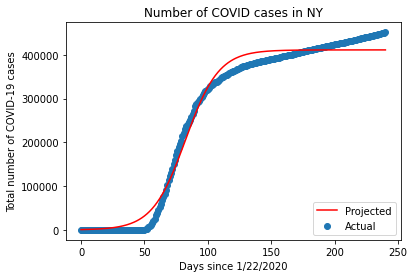

In [194]:
def plot_model(state, guessed_betas):
    ys = cases_by_state_over_time(state)
    xs = np.arange(len(ys))
    
    found_betas, covariance = curve_fit( logistic_curve, 
                                         xs, 
                                         ys, 
                                         p0=guessed_betas, 
                                         maxfev=5000 ) # Increases the allowed amount of iterations
    β0, β1, β2 = found_betas
    fit_model = lambda x: logistic_curve( x, β0, β1, β2 )

    plt.scatter( xs, ys )
    plt.plot( xs, fit_model( xs ), color='red' )
    plt.xlabel('Days since 1/22/2020')
    plt.ylabel('Total number of COVID-19 cases')
    plt.title(f'Number of COVID cases in {state}')
    plt.legend(labels = ['Projected', 'Actual'], loc = 'lower right')
    plt.show()

plot_model("NY", [cases_by_state_over_time("NY").max(), 1, len(cases_by_state_over_time("NY"))/2 ])

As seen in the example above, this model seems to fit the data for New York fairly well.
In blue we see the actual breakdown of COVID-19 cases over time.
In red we see the projected cases according to our model. 
Even when looking at other states, we are pleased to see that our model is accurately fitting the data.

However, let's take a look at our model's output for COVID-19 cases in North Dakota.

[1252427023.1131375, 0.01963044211799159, 807.0905363633083]


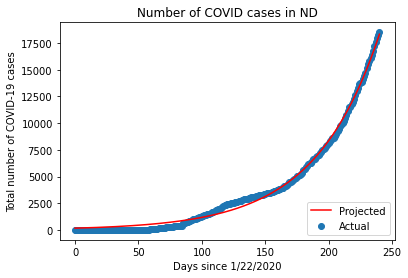

In [195]:
print(get_betas_regular("ND"))
plot_model("ND", [cases_by_state_over_time("ND").max(), 1, len(cases_by_state_over_time("ND"))/2 ])

While the model seems to fit the data for North Dakota well, if we look at the beta values that our model generated, we see that 
the model predicts that the maximum COVID-19 cases in North Dakota, in the long run, is 1.2 billion. This is likely because the number of cases 
in North Dakota has not peaked yet, and is still increasing very rapidly. 

We will remove the data for North Dakota from our DataFrame for future analysis.

In [196]:
merged_df = merged_df.drop("ND")

All of the other models look good so 

### Calculating and Storing Beta Values for Each State

Now that we have all of our beta values, we can write some code that will allow us to 
add all three beta values to individual columns of our DataFrame. We will start by getting 
a list of all the states.

In [197]:
state_list = merged_df.index.to_list()

We can then create a list that contains lists of all three beta values for each state.

In [198]:
# getting a list of the three beta values for each state
beta_list = []
for state in state_list:
    beta_list.append(get_betas_regular(state))

Next, we can write a function that separates our list of beta values into 3 different lists:
one containing just `β0` values, one containing `β1`, and one with `β2` values. 
We will zip each of these three lists together with our state lists and turn them into a dictionary
with our `beta_to_dict()` function.

In [199]:
# creating empty lists where we will separate the three betas 
beta0_list = []
beta1_list = []
beta2_list = []

def beta_to_dict(list_name, beta_number):
    for n in range(len(beta_list)):
        list_name.append(beta_list[n][beta_number]) # appending the individual beta value to the correct beta list (either 0,1, or 2)

    state_to_beta = dict(zip(state_list, list_name)) # creating a dictionary with state and the associated beta value 
    return state_to_beta

# calling the function for beta 0, beta 1, and beta 2
state_to_beta0 = beta_to_dict(beta0_list, 0)
state_to_beta1 = beta_to_dict(beta1_list, 1)
state_to_beta2 = beta_to_dict(beta2_list, 2)

state_to_beta0["NY"]

410972.5445920495

We can see that our function worked because the beta 0 value stored for New York in our
 dictionary is around 411,000. Which is the same as we saw earlier when computing the betas originally.

### Correlation Between Political Leaning and COVID-19 Variables

Now we can create a new DataFrame that only includes the variables that we want to test if
they are correlated with a state's political leaning. We start by resetting the 
DataFrame's index because we will need to be slicing the DataFrame by state.
This new DataFrame indexed by number rather than state and will be called `num_index_df`.

In [200]:
num_index_df = merged_df.reset_index() # so that we can slice the DataFrame by state

We start by creating an empty DataFrame. Our first column, `Political Leaning`, will show a state's political
leaning. We compute this by subtracting the percent of the 2016 votes that went to Clinton from
the percentage of votes that went to Trump. This means that a more Republican-leaning will be positive,
and those that are more Democrat-leaning will be negative.

In [201]:
correlation_df= pd.DataFrame()
correlation_df['Political Leaning'] = num_index_df['Trump Percentage'] - num_index_df['Clinton Percentage'] 

We can then add the most recent number of cases. This is simply the last column in our merged DataFrame. 
We can also add the most recent number of cases per capita by dividing that figure by the state's population.

In [202]:
correlation_df['Most Recent Cases'] = num_index_df.iloc[:,-1]
correlation_df['Most Recent Cases Per Capita'] = correlation_df['Most Recent Cases'] / num_index_df['population']

We can then use the `.map()` operation to create columns from our dictionaries of beta values 
that we created earlier. This will give us the maximum number of projected cases from `β0`, 
the rate of increase from `β1`, and the time of maximum increase from `β2`. We will also add maximum 
projected cases per capita by dividing by the state population, just as before.

In [203]:
correlation_df['Max Projected Cases (β0)'] = num_index_df['State'].map(state_to_beta0)
correlation_df['Max Projected Cases Per Capita'] = correlation_df['Max Projected Cases (β0)'] / num_index_df['population']
correlation_df['Rate of Increase (β1)'] = num_index_df['State'].map(state_to_beta1)
correlation_df['Time of Maximum Increase (β2)'] = num_index_df['State'].map(state_to_beta2)

correlation_df.head()

,Political Leaning,Most Recent Cases,Most Recent Cases Per Capita,Max Projected Cases (β0),Max Projected Cases Per Capita,Rate of Increase (β1),Time of Maximum Increase (β2)
0,15,6950,0.009500,8715.283648,0.011914,0.038377,205.937694
1,28,146584,0.029896,163696.835682,0.033386,0.037565,185.151303
2,26,76981,0.025509,84118.406576,0.027874,0.036137,187.644406
3,5,214846,0.029517,211619.069138,0.029074,0.061955,163.568481
4,-29,793250,0.020076,900101.939401,0.022780,0.036565,182.268455


Finally, we can use our new DataFrame to create a heatmap that shows the correlation between our
variables and the state's political leaning. We utilize the `.heatmap()` function from `sns`.

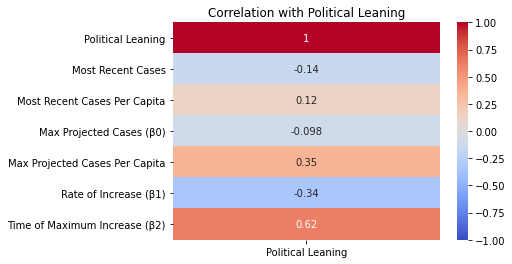

In [204]:
ax = plt.axes()
sns.heatmap(correlation_df.corr()[['Political Leaning']], 
                                    cmap='coolwarm',
                                    annot=True, # adds numbers to the boxes of the heat map
                                    vmin=-1, # allows correlationt o be from -1 to 1
                                    ax = ax) 
ax.set_title('Correlation with Political Leaning')
plt.show()

As with any heatmap, we are comparing variables to see how heavily correlated they are. 
Warmer colors portray stronger positive correlations, while cooler colors portray stronger negative correlations.
In our case, we are interested in seeing the correlation of each variable with `Political Leaning`.
Therefore, it makes sense that `Political Leaning` is perfectly correlated with itself as indicated by the coefficient of 1.
Of the variables included in the heatmap, the three variables that we are most interested 
in are `Max Projected Cases Per Capita`, `Rate of Increase (β1)`, and `Time of Maximum Increase (β2)`, since they have the 
strongest correlation coefficients.

### Hypothesis Testing

We can examine the relevance of these variables further by utilizing hypothesis tests. 
To test how these variables are related to a state's political leaning, we must first split our data
into two subsets. The first subset represents states that supported Trump, while the second subset 
represents states that supported Clinton. States that supported Trump are indicated by a `Political Leaning`
greater than zero. States that supported Clinton are indicated by a `Political Leaning`
less than zero.

In [205]:
leaning_Trump = correlation_df[correlation_df['Political Leaning'] > 0 ]
leaning_Clinton = correlation_df[correlation_df['Political Leaning'] < 0 ]

We define a function, `difference_in_means()`, that takes the column name as an argument and runs a hypothesis test for a difference in means of a 
variable between these two subsets, `leaning_Trump` and `leaning_Clinton`. The function will print the two means of the subpopulations 
of interest and return the p-value of the hypothesis test. We will use alpha = .05 for our significance level in all the tests.

In [206]:
def difference_in_means( column_name ):
    statistic, pvalue = stats.ttest_ind( leaning_Trump[column_name],
                                         leaning_Clinton[column_name],
                                         equal_var=False )
    print(f'Average {column_name} for Trump-supporting states: {leaning_Trump[column_name].mean():.4f}')
    print(f'Average {column_name} for Clinton-supporting states: {leaning_Clinton[column_name].mean():.4f}')                            
    print(f'P-Value: {pvalue:.5f}')

The first variable that we are interested in looking at further is the maximum projected cases per capita.
We can run a hypothesis test to see if the difference in the average maximum projected cases per capita between 
states that voted for Clinton and states that voted for Trump is statistically significant.

In [207]:
difference_in_means( "Max Projected Cases Per Capita" )

Average Max Projected Cases Per Capita for Trump-supporting states: 0.0261
Average Max Projected Cases Per Capita for Clinton-supporting states: 0.0157
P-Value: 0.00007


Running this hypothesis test gives us a p-value of .00007. Because this value is less than the significance level of .05,
this means that there is statistically significant evidence to conclude that the average maximum projected cases per capita
is different between Trump states and Clinton states. Based on the average values from the two populations, we can
conclude that the average maximum projected cases per capita is higher in Trump-supporting states
than in Clinton-supporting states.

We can run a similar test for the average rate of spread in the Trump States and the Clinton States.

In [208]:
difference_in_means( "Rate of Increase (β1)" )

Average Rate of Increase (β1) for Trump-supporting states: 0.0329
Average Rate of Increase (β1) for Clinton-supporting states: 0.0411
P-Value: 0.05086


We get a p-value of .05086. Because this value is slightly greater than the significance of .05, we cannot 
conclude that there is a statistically significant difference in the rate of spread for COVID-19 between states at the .05 level,
but there would be enough evidence at the .10 level. Therefore, there is certainly reason to be suspicious of a difference
in means, but this would have to be looked at further in future studies.

We also want to run a hypothesis test to see if the average time of maximum increase is
 different between states that voted Trump and states that voted Clinton.

In [209]:
difference_in_means( "Time of Maximum Increase (β2)" )

Average Time of Maximum Increase (β2) for Trump-supporting states: 194.1904
Average Time of Maximum Increase (β2) for Clinton-supporting states: 142.5263
P-Value: 0.00001


Running this test gives us a p-value of .00001. 
Because this value is less than the significance level of .05,
we have statistically significant    evidence to conclude
there is a difference in the time of maximum increase for states that 
support Trump compared to states that support Clinton.
Based on the means provided in the output, we can reasonably assume that 
the time of maximum increase is later in states that supported Trump 
than it is for states that supported Clinton.

## Bonus Questions

While it seems that our first model was fairly effective and yielded some interesting conclusions 
about the correlation between the 2016 elections and the spread of COVID-19 cases, some of the guesses for beta did
not give us good models. We could get more consistently accurate models by providing the `curve_fit` function with
better initial guessed values for the betas.

### Bonus #1
For example, we could use a similar function as before, but instead of our rough estimates, we could pass in 
up to 1,000 random numbers for each guessed beta value, stopping when the function finds a set of betas 
that converges. 

[900101.8553235147, 0.03656479545616013, 182.26844752355854]


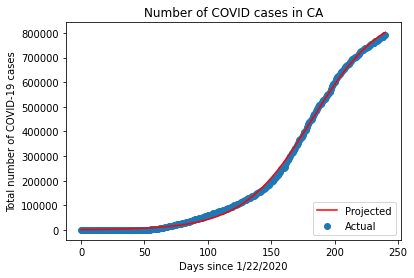

In [210]:
def get_betas_random(state):
    ys = cases_by_state_over_time(state)
    xs = np.arange(len(ys))

    converged = False # boolean for a while loop 
    count = 0 # creating a variable that will keep track of models we have tried
    
    # keep creating new models with random betas until we find one that converges or hit 1000 guesses 
    while not converged and count <= 1000:
        # randomly generate guessed betas from a slightly larger range than the observed in our data
        my_guessed_betas = [np.random.randint(1500, 500000), # beta 0
                             np.random.rand(), # beta 1
                             np.random.randint(80,240)] # beta 2

        found_betas, covariance = curve_fit( logistic_curve,
                                             xs,
                                             ys,
                                             p0=my_guessed_betas,
                                             maxfev=10000 ) # Increases the allowed amount of iterations
        β0, β1, β2 = found_betas

        # if the values for beta diverge they will be equal to infinite 
        if β0 != np.inf and β1 != np.inf and β2 != np.inf: 
            converged = True # loop will stop if it finds a model that converges
        else:
            count += 1
    return [β0, β1, β2]

print(get_betas_random("CA"))
plot_model('CA', [np.random.randint(1500, 500000), np.random.rand(), np.random.randint(80,240)])

The output shows the resulting beta values for California and a plot of the model against COVID-19 cases in California.
This could help us gather more suitable results for each state in the case that our original guesses resulted 
in a model that diverges.

### Bonus #2

We could improve this process even more if we generated 1000 models with randomly generated guessed beta values and
 returned the one with the least error. We can do this by calculating the goodness of fit for each model,
 finding the best fitting model, and retrieving the beta values from that model.

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/venv/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
[211619.01641553474, 0.06195508600312679, 163.568472169802]


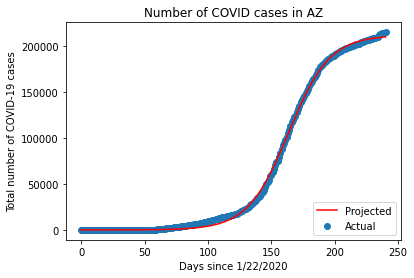

In [211]:
def get_betas_optimized(state):
    ys = cases_by_state_over_time(state)
    xs = np.arange(len(ys))
    guess_dict = {} # creating an empty dictionary for all 1000 guesses with their guess number and found betas
    goodness_of_fit = [] # creating an empty list to hold all calculated goodness of fits

    for guess in range(1000):
        # Guessed betas are randomly generated numbers from a slightly larger range than the observed range of each beta value
        my_guessed_betas = [np.random.randint(1500, 500000), # Beta 0
                            np.random.rand(), # Beta 1
                            np.random.randint(0,240)] # Beta 2

        found_betas, covariance = curve_fit( logistic_curve, 
                                            xs, 
                                            ys, 
                                            p0=my_guessed_betas, 
                                            maxfev=100000000 ) # maxfev increases the allowed amount of iterations
        β0, β1, β2 = found_betas

        # We calculate goodness of fit by computing sum squared difference
        goodness_of_fit.append(sum((logistic_curve(xs, β0, β1, β2) - ys) **2)) #sum of squared differences between expected and observed

        guess_dict[guess] = found_betas # adding to the dictionary each set of betas associated with a guess number
     
    optimized_goodness_of_fit = goodness_of_fit.index(min(goodness_of_fit)) # finding index of the lowest sum squared difference
    best_guesses = guess_dict[optimized_goodness_of_fit] # returning the beta values associated with the best guess
    return list(best_guesses)

print(get_betas_optimized("AZ"))
plot_model("AZ", [np.random.randint(1500, 500000), np.random.rand(), np.random.randint(80,240)])


The resulting output shows the beta values for Arizona as well as a plot of the number of COVID-19
cases in Arizona against our optimized model. As you can see the resulting beta values are very close to the 
last calculation but slightly different. This method results in a much higher chance that we give the `curve_fit()`
function good guessed beta values. As a result, this function has a greater chance of creating a good model.